# Stock price predicting using recurring neural network
By Nate Bowers

### Import statements


In [125]:
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn.model_selection import TimeSeriesSplit


### Collecting stock ticker, 10 years of price and volume data, and calculating 30 day moving price average

In [126]:
ticker = input("Enter the stock ticker you would like to create a model for: ").upper()

Text(0.5, 1.0, '10 years of AAPL Price')

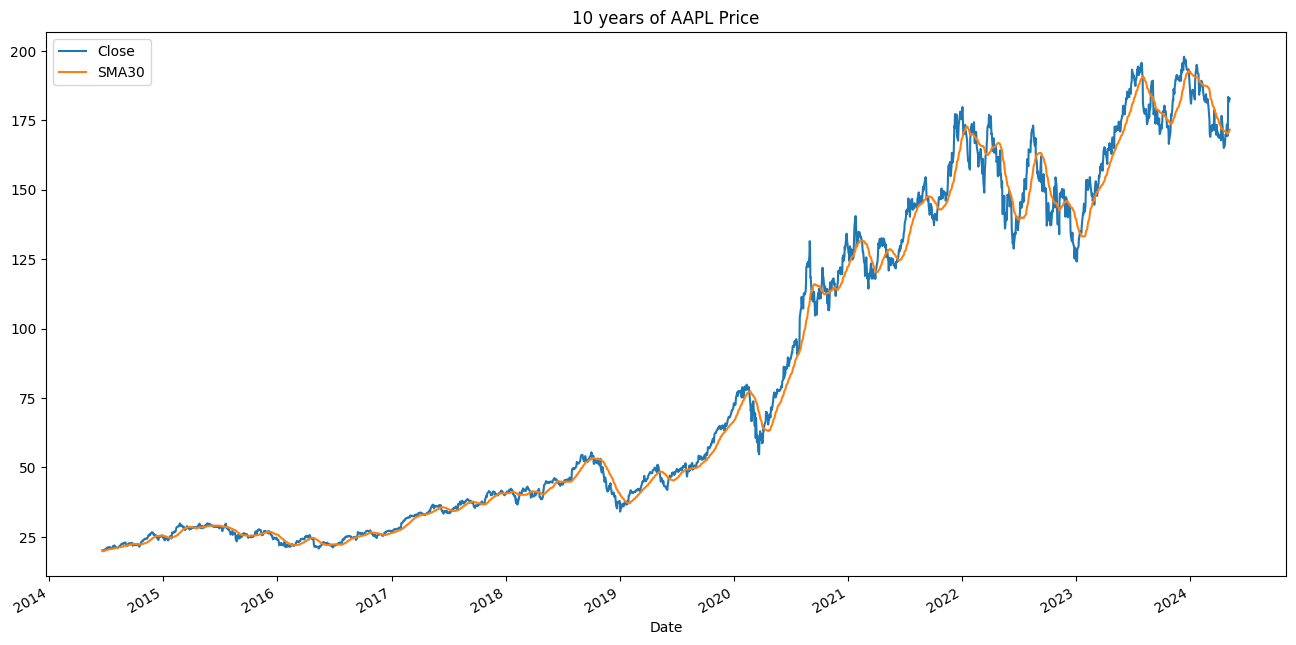

In [127]:
msft = yf.Ticker(ticker)

hist = msft.history(period="10y")

hist = hist.drop(columns=["Open", "High", "Low","Stock Splits", "Dividends"])

# Calculate 30-day Simple Moving Average (SMA)
hist['SMA30'] = hist['Close'].rolling(30).mean()
 
# Remove NULL values
hist.dropna(inplace=True)

hist.head()
#plot = plt.plot(hist["Close"])
hist[['Close', 'SMA30']].plot(figsize=(16, 8))
plt.title("10 years of " + ticker + " Price")


## Dividing data into training and test

In [128]:
ts_cv = TimeSeriesSplit(
    n_splits=10,  
    gap=48  
)

# These lines are overwritten because they cause training data to be lost. IGNORE
all_splits = list(ts_cv.split(hist, hist["Close"] ))
train_idx, test_idx = all_splits[0]
X_train, X_test = hist.iloc[train_idx], hist.iloc[test_idx]
y_train, y_test = hist["Close"].iloc[train_idx], hist["Close"].iloc[test_idx]

In [129]:
#This code splits training into first 9 years, and test as the last year
X_train = hist[:2250]
X_test = hist[2250:2518]

y_train = hist["Close"][:2250]
y_test = hist["Close"][2250:2518]

#Uncomment for 30 days of predictions. IGNORE
#X_test = hist[2250:2280]
#y_test = hist["Close"][2250:2280]

In [130]:

# y data shift up one to predict tmrws close, not todays
y_test = y_test.shift(-1,axis=0)
y_train = y_train.shift(-1,axis=0)
y_train.head(3)

#remove last x value in train and test and empty y value at end
X_train.drop(X_train.tail(1).index,
        inplace = True)

X_test.drop(X_test.tail(1).index,
        inplace = True)

y_test.drop(y_test.tail(1).index,
        inplace = True)

y_train.drop(y_train.tail(1).index,
        inplace = True)

/var/folders/9x/hp4yd9t517q0b2m13pghld080000gn/T/ipykernel_12444/740433050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(X_train.tail(1).index,
/var/folders/9x/hp4yd9t517q0b2m13pghld080000gn/T/ipykernel_12444/740433050.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(X_test.tail(1).index,


## Recuring Nueral Network - Long short term memory layers
Sequential - linear layers.  
Dense: standard NN layer
LSTM:layer used for time series data
Dropout: randomly ignore neurons to avoid overfitting

In [131]:
#Create model and add LSTM, Dense, and Dropout layers
model = keras.models.Sequential() 
model.add(keras.layers.LSTM(units=64, 
                            return_sequences=True, 
                            input_shape=(X_train.shape[1], 1))) 
model.add(keras.layers.LSTM(units=64)) 
model.add(keras.layers.Dense(32)) 
model.add(keras.layers.Dropout(0.3)) 
model.add(keras.layers.Dense(1)) 
model.summary 

/Users/natebowers/Documents/ATCS/TradingML/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential_11, built=True>>

In [132]:
model.compile(optimizer='adam', 
              loss='mean_squared_error') 

#Train model on training data for 50 epochs
history = model.fit(X_train, 
                    y_train, 
                    epochs=50)

Epoch 1/50


## Making Predictions

In [ ]:
# predict the testing data using model 
predictions = model.predict(X_test) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


# Results

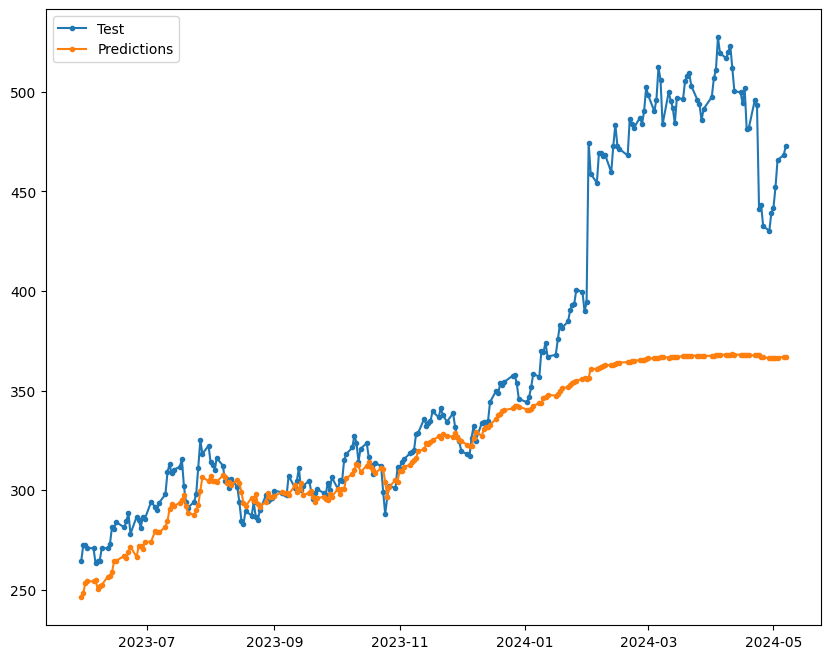

In [ ]:
#Plot test price data and price predictions to estimate accuracy of model
plt.figure(figsize=(10, 8)) 
#plt.plot(X_train.index, y_train) 
plt.plot(X_test.index, y_test, marker = ".") 
plt.plot(X_test.index, predictions, marker = ".") 
plt.legend(['Test', 'Predictions']) 


## Calculating Accuracy based on if model predicts correct direction of movement

In [ ]:
correct = 0

x_vals= X_test["Close"].values
y_vals = y_test.values

#Count percent of times model predicted correct direction of price movement
i = 0
for i in range(len(x_vals)):
    real_movement = x_vals[i] - y_vals[i]
    predicted_movement = x_vals[i] - predictions[i]
    if (real_movement > 0 and predicted_movement > 0) or (real_movement < 0 and predicted_movement < 0):
        correct += 1

print("% Correct: " + str(100 * correct/len(predictions)))


% Correct: 46.413502109704645
